Note: i uploaded the algo though Jupyter Notebook because it is the more efficient way. If you want to run the algo you just need to create a Quantopian account and copy the code into a new algo document

### Algo imports

In [ ]:
from __future__ import division

# building the trading universe
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.factors import Returns, MarketCap
from quantopian.pipeline.data import USEquityPricing, Fundamentals
from quantopian.pipeline.filters import QTradableStocksUS, StaticAssets
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import SimpleMovingAverage

# manipulating data 
import pandas as pd
import numpy as np
import re

# preprocessing data and optimization
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# risk parity
from numpy.linalg import inv, pinv
from scipy.optimize import minimize

# algo import
import quantopian.algorithm as algo

### Strategy description

The strategy is based on S&P500: it computes some fundamental indicators such as Roe increase in the last 2 months, net profit margin increase in the last 2 months, earnings on price ratio increase in the last 2 months, free cash flows, returns and equity on debt increase in the last 2 months. Then data is standardize and combined to compute a score, on which the final rank is built. Once we have this rank, we long the first 50 companies and sort the last 50. As you can see the only 'technical' indicator is Return: this is why the strategy is more suitable for long term investment rather than intraday operations. The last step is to compute portfolio weights: i decided to use risk parity in order to minize expsoure to volatility

In [ ]:
# scheduling the algo
def initialize(context):
    
    # Rebalance every day, 1 hour after market open.
    algo.schedule_function(
        rebalance,
        algo.date_rules.week_end(1),
        algo.time_rules.market_open(hours = 2),
    )

    # Record tracking variables at the end of each day.
    algo.schedule_function(
        my_record,
        algo.date_rules.every_day(),
        algo.time_rules.market_close(),
    )
    
    algo.schedule_function(
        before_trading_start,
        algo.date_rules.every_day(),
        algo.time_rules.market_close(),
    )

    # Create our dynamic stock selector.
    algo.attach_pipeline(make_pipeline(), 'pipeline')

class Make_Window_Safe(CustomFactor):
    window_length = 1
    window_safe = True
    def compute(self, today, assets, out, input_factor): 
        out[:] = input_factor
        
class Factor_N_Days_Ago(CustomFactor):
    def compute(self, today, assets, out, input_factor): 
        out[:] = input_factor[0]

# building the dataset
def make_pipeline():
    
    # Get open, close and market cap
    close_price = USEquityPricing.close.latest
    open_price = USEquityPricing.open.latest
    market_cap = MarketCap()
    
    # Get S&P 500
    QTU = QTradableStocksUS()
    top_500_market_cap = market_cap.top(500)
    
    # Create the enviroment
    QTU_top_500 = QTU & top_500_market_cap
    
    # Take only companies with closing price 
    has_pricing_data = close_price.notnull()
    
    # Get the sector
    morningstar_sector = Sector()
    
    # Get factors
    returns = (close_price - open_price) / open_price
    
    roe = Fundamentals.roe.latest
    
    net_profit_margin = Fundamentals.net_income_income_statement.latest / Fundamentals.total_revenue.latest
    
    EP_ratio = 1 / morningstar.valuation_ratios.pe_ratio.latest
    
    fcf = Fundamentals.free_cash_flow.latest / close_price
    
    ED = 1 / Fundamentals.total_debt_equity_ratio.latest
    
    # Make the factors 'window_safe'. Only do this if you are sure they are!
    roe_ws = Make_Window_Safe(inputs = [roe])
    net_profit_margin_ws = Make_Window_Safe(inputs = [net_profit_margin])
    EP_ratio_ws = Make_Window_Safe(inputs = [EP_ratio])
    fcf_ws = Make_Window_Safe(inputs = [fcf])
    ret_ws = Make_Window_Safe(inputs = [returns])

    # Get factors from 2 weeks ago
    previous_2wks = (2 * 5) + 1
    roe_2wks_ago = Factor_N_Days_Ago(inputs = [roe_ws], window_length = previous_2wks)
    net_profit_margin_2wks_ago = Factor_N_Days_Ago(inputs = [net_profit_margin_ws], window_length = previous_2wks)
    EP_ratio_2wks_ago = Factor_N_Days_Ago(inputs = [EP_ratio_ws], window_length = previous_2wks)
    fcf_2wks_ago = Factor_N_Days_Ago(inputs = [fcf_ws], window_length = previous_2wks)
    ret_2wks_ago = Factor_N_Days_Ago(inputs = [ret_ws], window_length = previous_2wks)

    # Get factors from 8 weeks ago
    previous_8wks = (8*5) + 1
    roe_8wks_ago = Factor_N_Days_Ago(inputs = [roe_ws], window_length = previous_8wks)
    net_profit_margin_8wks_ago = Factor_N_Days_Ago(inputs=[net_profit_margin_ws], window_length = previous_8wks)
    EP_ratio_8wks_ago = Factor_N_Days_Ago(inputs = [EP_ratio_ws], window_length = previous_8wks)
    fcf_8wks_ago = Factor_N_Days_Ago(inputs = [fcf_ws], window_length = previous_8wks)
    ret_8wks_ago = Factor_N_Days_Ago(inputs = [ret_ws], window_length = previous_8wks)
    
    # Ratios of 2/8 weeks ago
    roe_2_8wks_ago = roe_2wks_ago / roe_8wks_ago
    net_profit_margin_2_8wks_ago = net_profit_margin_2wks_ago / net_profit_margin_8wks_ago
    EP_ratio_2_8wks_ago = EP_ratio_2wks_ago / EP_ratio_8wks_ago
    fcf_2_8wks_ago = fcf_2wks_ago / fcf_8wks_ago
    ret_2_8_wks_ago = ret_2wks_ago / ret_8wks_ago
    
    return Pipeline(columns = {'close_price': close_price, 
                               'Sector_Id' : morningstar_sector,  
                               'Roe' : roe, 
                               'E/P' : EP_ratio_2_8wks_ago, 
                               'FCF/P' : fcf_2_8wks_ago, 
                               'open_price' : open_price,  
                               'NPM' : net_profit_margin,
                               'Returns' : returns,
                               'E/D' : ED},  
                    screen = QTU_top_500 & has_pricing_data)


def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    context.output = algo.pipeline_output('pipeline')

    # These are the securities that we are interested in trading each day.
    context.security_list = context.output.index

# making orders
def rebalance(context, data):
    
    long_secs, short_secs = standardize(context, data)
    long_weight, short_weight = get_weights(context, data)
    
    i = 0
    for longs in long_secs:
        if data.can_trade(longs):
            order_target_percent(longs, long_weight[i])
            i += 1

    i = 0   
    for short in short_secs:
        if data.can_trade(short):
            order_target_percent(short, -short_weight[i])
            i += 1
    
    for asset in context.portfolio.positions:
        if data.can_trade(asset) and asset not in long_secs and asset not in short_secs:
            order_target_percent(asset, 0)

# recording positions
def my_record(context, data):
    long_count = 0
    short_count = 0
    
    for position in context.portfolio.positions.values():
        if position.amount > 0:
            long_count += 1
        elif position.amount < 0:
            short_count += 1

# computing portfolio weights
def get_weights(context, data):
    long_secs , short_secs = standardize(context, data)
    prices = data.history(long_secs + short_secs, 'close', 600,'1d')
    returns = prices.pct_change()
    returns.dropna(inplace = True)
    df_cov = returns.cov()
    n = len(df_cov)
    x_t = [1 / n for i in range(n)]
    w0 = np.ones((n)) * (1/0.25)
    
    # function that calculates portfolio risk
    def calculate_portfolio_var(w,V):
        w = np.matrix(w)
        return (w*V*w.T)[0,0]
    
    # function that calculates asset contribution to total risk
    def calculate_risk_contribution(w,V):
        w = np.matrix(w)
        sigma = np.sqrt(calculate_portfolio_var(w, V))
        MRC = V * w.T
        RC = np.multiply(MRC, w.T) / sigma
        return RC
    # calculate portfolio risk
    def risk_budget_objective(x,pars):
        V = pars[0] 
        x_t = pars[1] 
        sig_p =  np.sqrt(calculate_portfolio_var(x, V)) 
        risk_target = np.asmatrix(np.multiply(sig_p, x_t))
        asset_RC = calculate_risk_contribution(x,V)
        J = sum(np.square(asset_RC-risk_target.T))[0, 0] 
        return J

    def total_weight_constraint(x):
        return np.sum(x)-1.0

    def long_only_constraint(x):
        return x

    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    res = minimize(risk_budget_objective, w0, args = [np.array(df_cov), x_t], method='SLSQP',
                  constraints = cons, options = {'disp' : True})
    w_rb = np.asmatrix(res.x)
    return w_rb.tolist()[0][:len(long_secs)], w_rb.tolist()[0][len(short_secs):]

# function used to compute the stock tickers on which i want to trade           
def standardize(context, data):
    df = context.output
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    columns = ['Returns', 'E/D', 'Roe', 'NPM', 'FCF/P', 'E/P']
    df[columns] = StandardScaler().fit_transform(df[columns])
    df['rank'] = (df['Returns'] + df['E/D'] + df['Roe'] + df['NPM'] + df['FCF/P'] +df['E/P']) / 6
    df.sort_values(by = 'rank', ascending = False)
    return df.index[:50], df.index[-50:]

### Final comments

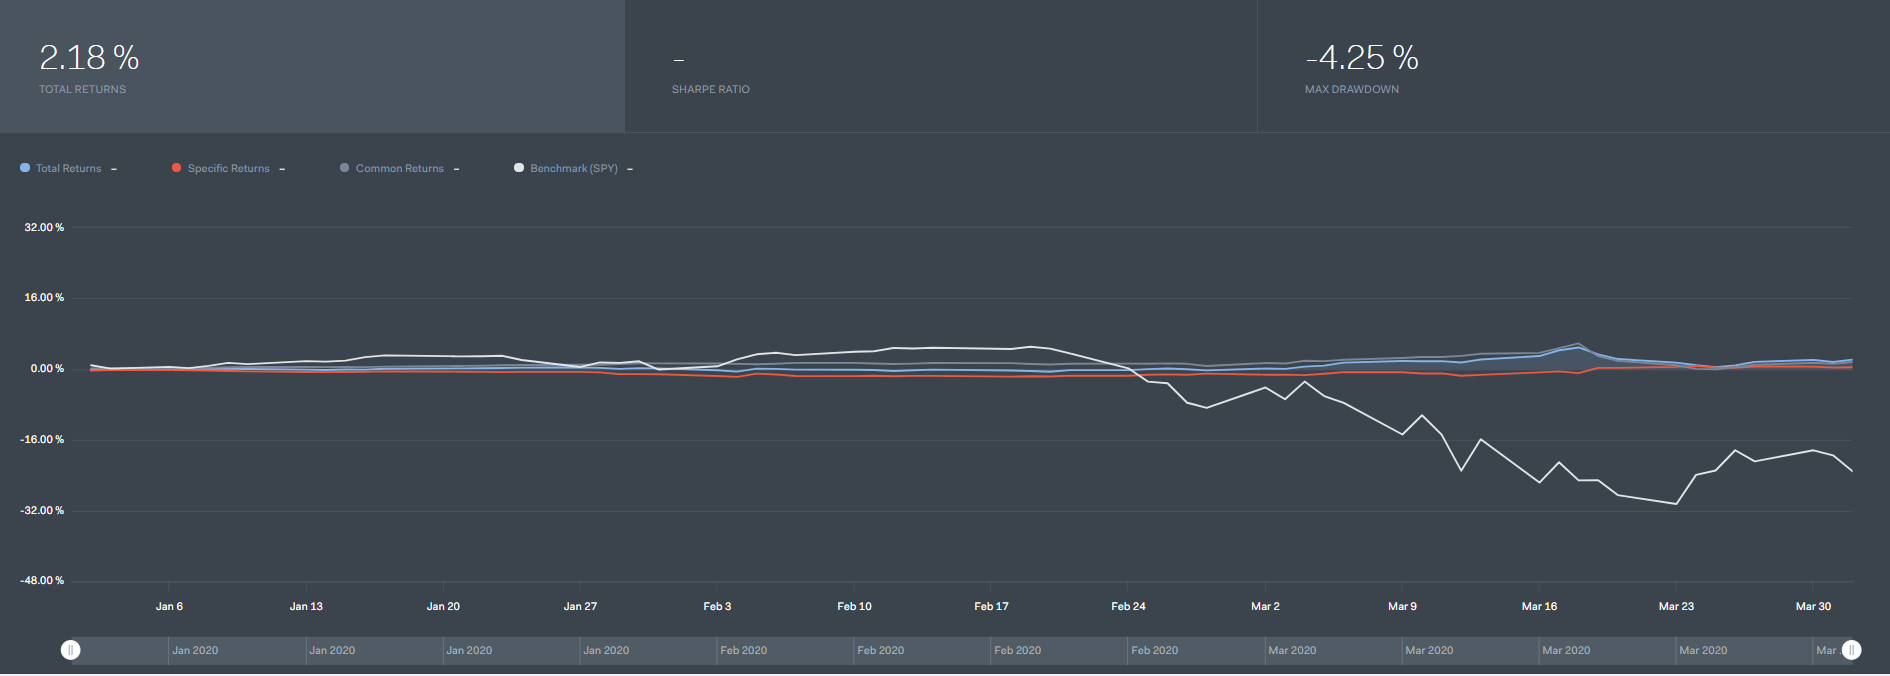

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

report = Image.open(r'C:\Users\Aless\Downloads\Algo.PNG')
report

This is the report of the algo for the Covid-19 crysis period. As we can see it overperformed the benchmark by far (2.18% vs about -23%). because the sort timeframe the report does not provide the Sharpe ratio, a quick computation asses it at 2.00